In [1]:

from env import routes

import carla
from carla_agents.navigation.basic_agent import BasicAgent
from carla_agents.navigation.local_planner import RoadOption

import queue
import os
import numpy as np
import argparse
import datetime
import random
import math
import matplotlib.pyplot as plt
from distutils.util import strtobool
import pygame
from pygame.locals import K_q
from pygame.locals import K_p
from pygame.locals import K_w
from pygame.locals import K_a
from pygame.locals import K_s
from pygame.locals import K_d

from RL_utils.custom_utils import World,KeyboardControl,HUD

pygame 2.6.0 (SDL 2.28.4, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
CFG={
    'host':'127.0.0.1',
    'port':2000,
    'res':'256x112',
    'vehicle':'model3',
    'map':'Town05',#'Town02_Opt',
    'fps':30,
    'save-png':False,
    'no_screen':True,
    'record':True,
    'autopilot':True,
    'num-episodes':1,
    'spawns':routes.town_5_train_spawns,#routes.train_spawns,town_5_train_spawns
    'rotations' : routes.town_5_train_rotations,
    'dests': routes.town_5_train_dests,
    'episode_number':0



}
width,height=CFG['res'].split('x')
width=int(width)
height=int(height)
print('HOST: ',CFG['host'])
print('PORT: ',CFG['port'])
print('width: ',width)
print('height: ',height)


HOST:  127.0.0.1
PORT:  2000
width:  256
height:  112


In [3]:
client=carla.Client(CFG['host'],CFG['port'])
client.set_timeout(60.0)
world=client.load_world('Town05')
map=world.get_map()
spawn_points=map.get_spawn_points()
print(len(spawn_points))
number=222
spawn_points=spawn_points[number]
rotation=spawn_points.rotation
print(f"X:{spawn_points.location.x},Y:{spawn_points.location.y},Z:{spawn_points.location.z}")
print(f"Pitch: {rotation.pitch}, Yaw: {rotation.yaw}, Roll: {rotation.roll}")

blueprint_library=world.get_blueprint_library()
vehicle_bp=blueprint_library.filter('vehicle')[0]
vehicle=world.try_spawn_actor(vehicle_bp,spawn_points)
if vehicle is not None:
    print("Vehicle spawned successfully")
else:
    print("Failed to spawn vehicle")
spawn_points=map.get_spawn_points()
spawn_points=spawn_points[301-number]
rotation=spawn_points.rotation
print(f"X:{spawn_points.location.x},Y:{spawn_points.location.y},Z:{spawn_points.location.z}")
print(f"Pitch: {rotation.pitch}, Yaw: {rotation.yaw}, Roll: {rotation.roll}")
blueprint_library=world.get_blueprint_library()
vehicle_bp=blueprint_library.filter('vehicle')[0]
vehicle=world.try_spawn_actor(vehicle_bp,spawn_points)
if vehicle is not None:
    print("Vehicle spawned successfully")
else:
    print("Failed to spawn vehicle")

302
X:41.803245544433594,Y:92.05677795410156,Z:0.29999998211860657
Pitch: 0.0, Yaw: -0.41619873046875, Roll: 0.0
Vehicle spawned successfully
X:34.04145050048828,Y:-116.16455078125,Z:0.29999998211860657
Pitch: 0.0, Yaw: -88.46794891357422, Roll: 0.0
Vehicle spawned successfully


In [4]:
if CFG['no_screen']:
    os.environ['SDL_VIDEODRIVER'] = 'dummy'
pygame.init()
world = None
try:
    client=carla.Client(CFG['host'],CFG['port'])
    client.set_timeout(60.0)
finally:
    pass

for eps in range(CFG['num-episodes'] * len(CFG['spawns'])):
    pygame.font.init()
    

    idx = eps // CFG['num-episodes']
    CFG['episode_number'] = eps

    spawn = CFG['spawns'][idx]
    dest = CFG['dests'][idx]
    rotation = CFG['rotations'][idx]

    if CFG['num-episodes']> 1 and eps % CFG['num-episodes'] != 0:
        shift = 5 * random.random()
        if rotation.yaw == 0:
            spawn.x += shift
        elif rotation.yaw == 90:
            spawn.y += shift
        elif rotation.yaw == 180:
            spawn.x -= shift
        elif rotation.yaw == 270:
            spawn.y -= shift
    try:
        sim_world = client.load_world(CFG['map'])
        settings = sim_world.get_settings()
        settings.synchronous_mode = True
        settings.fixed_delta_seconds = 1 / CFG['fps']
        sim_world.apply_settings(settings)
        display = pygame.display.set_mode((width, height), pygame.HWSURFACE | pygame.DOUBLEBUF)
        display.fill((0, 0, 0))
        pygame.display.flip()

        hud = HUD(width,  height)
        world = World(sim_world, hud, CFG,idx)
        controller = KeyboardControl(world, autopilot_enabled=CFG['autopilot'])

        if CFG['record']:
            world.toggle_recording()

        sim_world.tick()
        clock=pygame.time.Clock()
        count=-1
        while not world.agent.done():

            sim_world.tick()
            clock.tick_busy_loop(CFG['fps'])
            controller.parse_events(world, clock)
            world.tick(clock)
            world.render(display)
            pygame.display.flip()
            world.record()
            count+=1
            if count>10000:
                break
        # stop recording
        if CFG['record']:
            world.toggle_recording()
    finally:
        if world is not None:
            world.destroy()
        pygame.quit()

In [5]:
action=np.load('F:/VSC/graduate_for_simulator/expert_data/eps_0/expert_actions.npy')
commands=np.load('F:/VSC/graduate_for_simulator/expert_data/eps_0/expert_commands.npy')
speeds=np.load('F:/VSC/graduate_for_simulator/expert_data/eps_0/expert_speeds.npy')
states=np.load('F:/VSC/graduate_for_simulator/expert_data/eps_0/expert_states.npy')

(1228, 3)


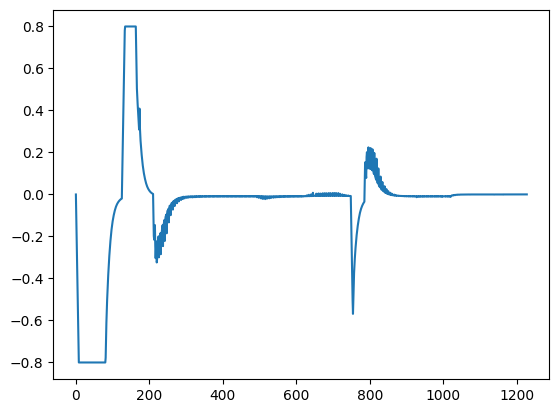

In [6]:
action=np.array(action)

print(action.shape)

plt.plot(action[:,1])

# 이미지

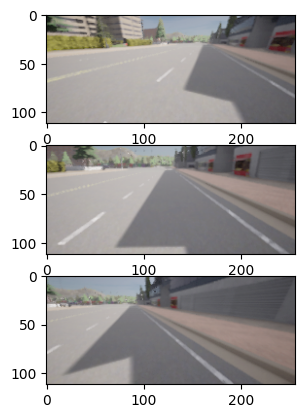

In [7]:
plt.subplot(3,1,1)
plt.imshow(states[280][:3].transpose(1,2,0)/255.)
plt.subplot(3,1,2)
plt.imshow(states[280][3:6].transpose(1,2,0)/255.)
plt.subplot(3,1,3)
plt.imshow(states[280][6:9].transpose(1,2,0)/255.)

# action

가속, 조향, 브레이크

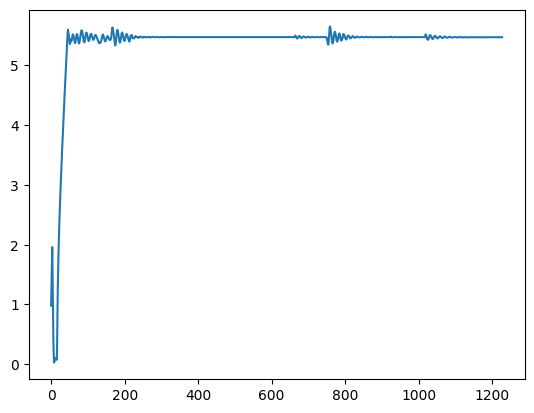

In [8]:
plt.plot(speeds)

#커맨드

In [9]:
commands

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)